### ResNet50 Keras baseline model

This notebook takes you through some important steps in building a deep convnet in Keras for multilabel classification of brain CT scans. 


*Update (1):*
* *training for 4 epochs instead of 3.*
* *batch size lowered to 16 from 32.*
* *training without learning rate decay.*
* *Weighted BCE instead of "plain" BCE*
* *training data lowered to 80% from 90%.*


*Update (2):*
* *adding competition metric for training*
* *using custom Callback for validation and test sets instead of the `run()` function and 'global epochs'*
* *training with "plain" BCE again*
* *merging TestDataGenerator and TrainDataGenerator into one*
* *adding undersampling (see inside `on_epoch_end`), will now run 6 epochs*

*Update (3):*
* *skipping/removing windowing (value clipping), but the transformation to Hounsfield Units is kept*
* *removing initial layer (doing np.stack((img,)&ast;3, axis=-1)) instead*
* *reducing learning rate to 5e-4 and add decay*
* *increasing batch size to 32 from 16*
* *Increasing training set to 90% of the data (10% for validation)*
* *slight increase in undersampling*
* *fixed some hardcoding for input dims/sizes*

In [0]:
import collections
from datetime import datetime
from math import ceil, floor
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import sys



import cv2
import keras
import tensorflow as tf



from keras_applications.resnet import ResNet50
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import ShuffleSplit





test_images_dir = 'data/'
train_images_dir = 'data/'





data/image1.jpg


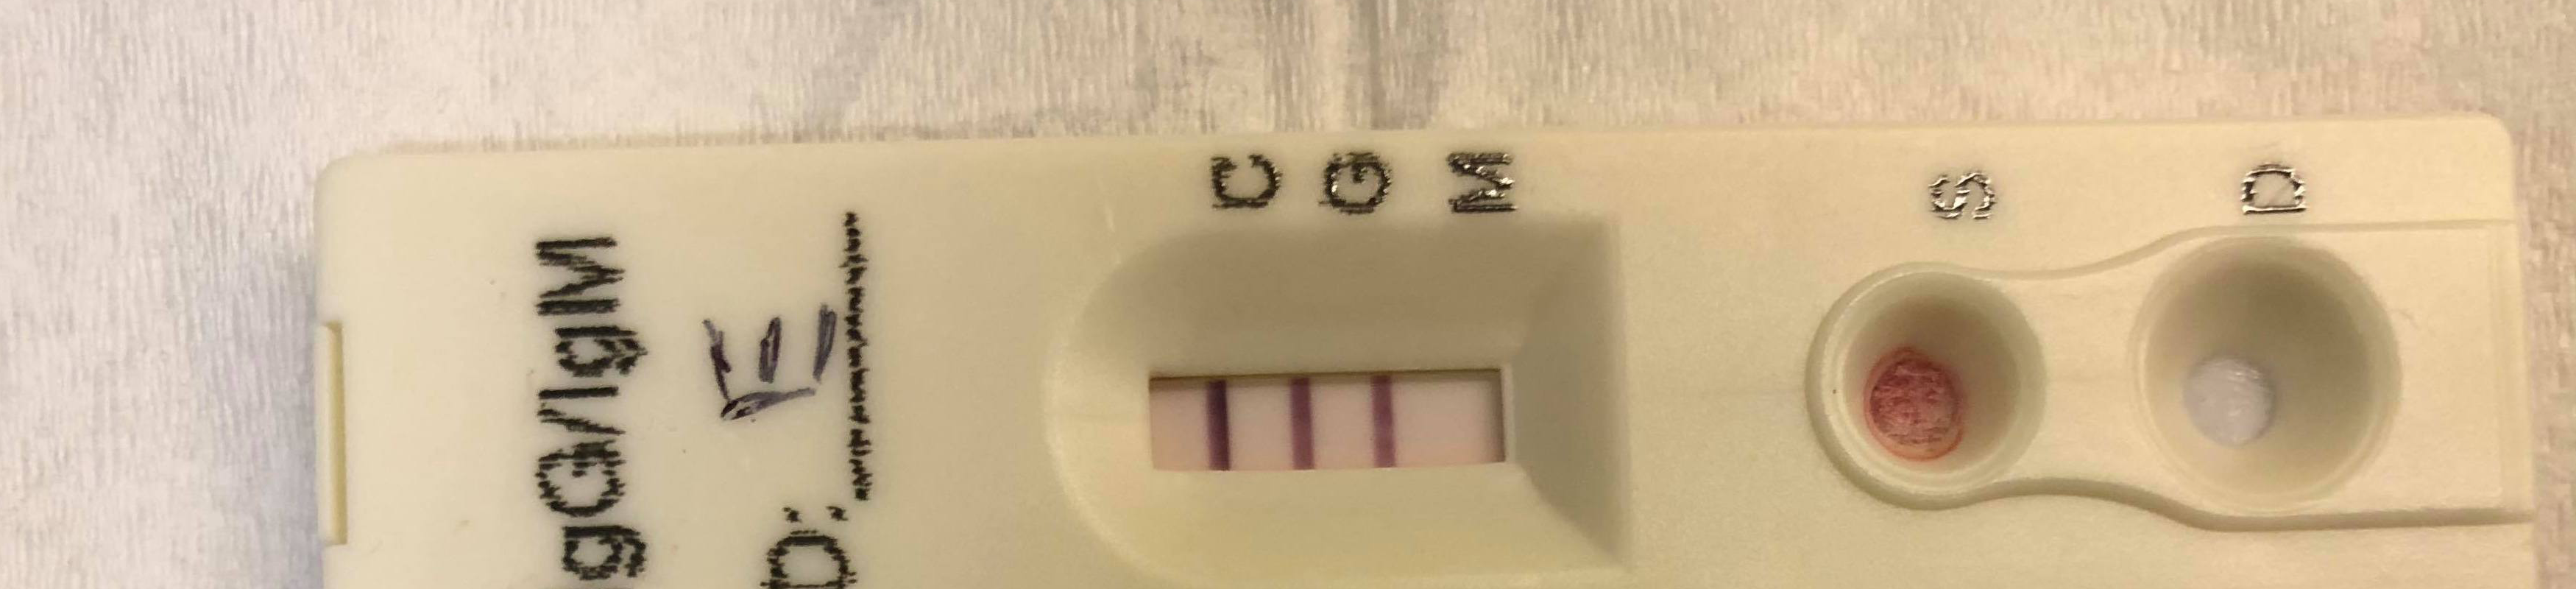

data/image2.jpg


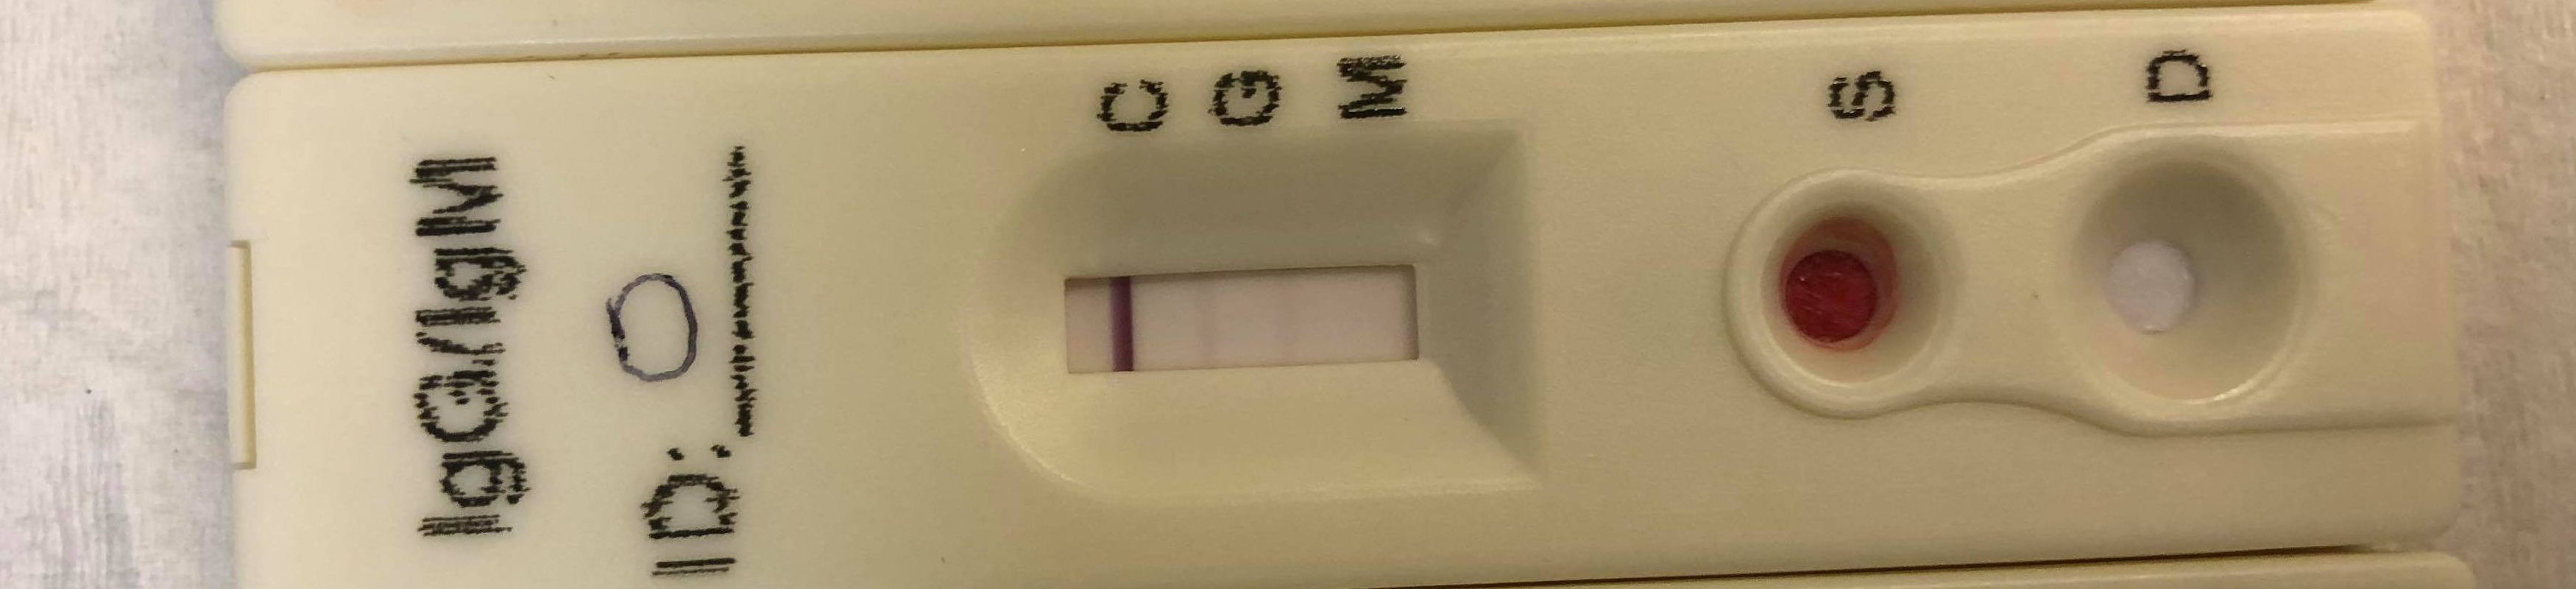

data/image0.jpg


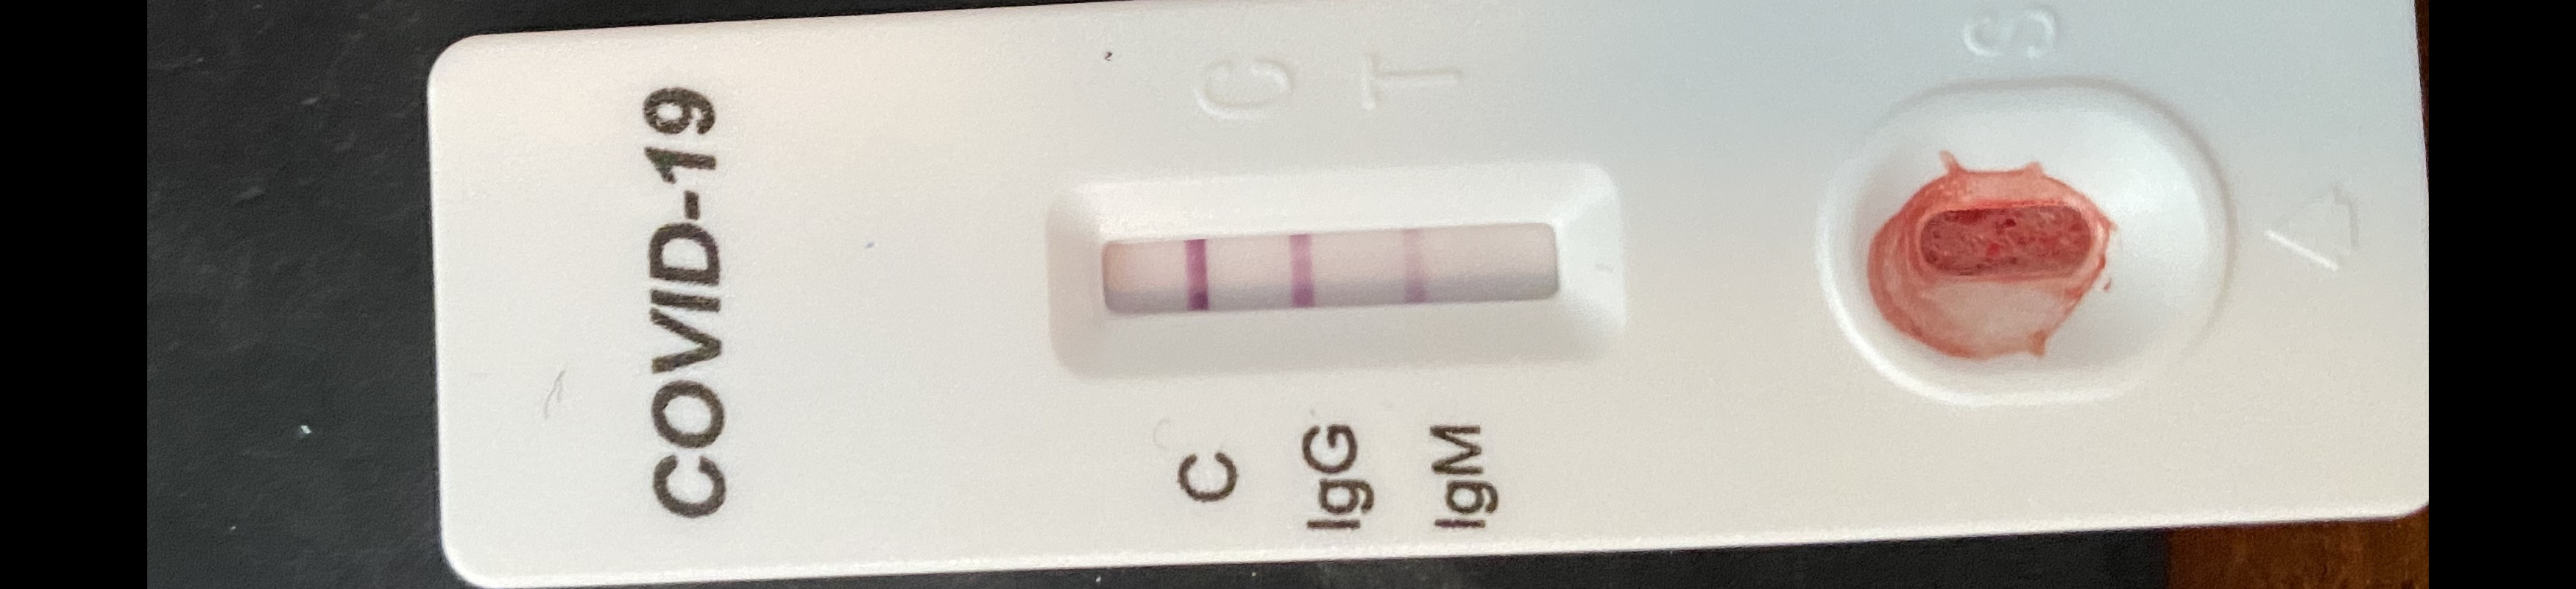

In [71]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

data_dir = pathlib.Path(".")
images = list(data_dir.glob('data/*.jpg'))

for image_path in images[:3]:
    print(image_path)
    im = Image.open(str(image_path))
    #display.display(im)
    width, height = im.size   # Get dimensions
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    display.display(im)

### 1. Helper functions

* normalizing the pixel values between -1 and 1 
* read and transform dcms to 3-channel inputs for e.g. ResNet50.

\* Source for windowing (although now partly removed from this kernel): https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing

In [0]:
def _normalize(img):
    if img.max() == img.min():
        return np.zeros(img.shape)-1
    return 2 * (img - img.min())/(img.max() - img.min()) - 1


  
def _read(path, desired_size):
    """Will be used in DataGenerator
    We assume that the image has been centered
    """
    new_width, new_height = desired_size

    im = Image.open(str(image_path))
    width, height = im.size   # Get dimensions
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    im = np.array(im.crop((left, top, right, bottom)))
    img = _normalize(im)
    return np.stack((img,)*3, axis=-1)


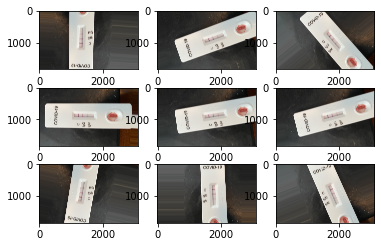

In [73]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

img = load_img('data/image0.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range = 90, width_shift_range=[-200,200])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

### 2. Data generators

Inherits from keras.utils.Sequence object and thus should be safe for multiprocessing.


In [0]:


class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, labels=None, batch_size=1, img_size=(512, 512, 3), 
                 img_dir=train_images_dir, shuffle=True, *args, **kwargs):

        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        if self.labels is not None:
            X, Y = self.__data_generation(list_IDs_temp)
            return X, Y
        else:
            X = self.__data_generation(list_IDs_temp)
            return X
        
    def on_epoch_end(self):
        #if self.labels is not None: # for training phase we undersample and shuffle
            # keep probability of any=0 and any=1
            # keep_prob = self.labels.iloc[:, 0].map({0: 0.4, 1: 0.8})
            # keep = (keep_prob > np.random.rand(len(keep_prob)))
            # self.indices = np.arange(len(self.list_IDs))[keep]
        #    np.random.shuffle(self.indices)
        #else:
        #    self.indices = np.arange(len(self.list_IDs))
        self.indices = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size))
        
        if self.labels is not None: # training phase
            Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".jpg", self.img_size)
                Y[i,] = self.labels.loc[ID].values
        
            return X, Y
        
        else: # test phase
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            
            return X

### 3a. loss function and metric

In [0]:
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)


def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for the this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)


def weighted_log_loss_metric(trues, preds):
    """
    Will be used to calculate the log loss 
    of the validation set in PredictionCheckpoint()
    ------------------------------------------
    """
    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()

### 3b. Model

Model is divided into three parts: <br> 

* (REMOVED) The initial layer, which will transform/map input image of shape (\_, \_, 1) to another "image" of shape (\_, \_, 3).

* The new input image is then passed through ResNet50 (which I named "engine"). ResNet50 could be replaced by any of the available architectures in keras_application.

* Finally, the output from ResNet50 goes through average pooling followed by a dense output layer.

In [0]:
class PredictionCheckpoint(keras.callbacks.Callback):
    
    def __init__(self, test_df, valid_df, 
                 test_images_dir=test_images_dir, 
                 valid_images_dir=train_images_dir, 
                 batch_size=32, input_size=(224, 224, 3)):
        
        self.test_df = test_df
        self.valid_df = valid_df
        self.test_images_dir = test_images_dir
        self.valid_images_dir = valid_images_dir
        self.batch_size = batch_size
        self.input_size = input_size
        
    def on_train_begin(self, logs={}):
        self.test_predictions = []
        self.valid_predictions = []
        
    def on_epoch_end(self,batch, logs={}):
        self.test_predictions.append(
            self.model.predict_generator(
                DataGenerator(self.test_df.index, None, self.batch_size, self.input_size, self.test_images_dir), verbose=2)[:len(self.test_df)])
        
        self.valid_predictions.append(
            self.model.predict_generator(
                DataGenerator(self.valid_df.index, None, self.batch_size, self.input_size, self.valid_images_dir), verbose=2)[:len(self.valid_df)])
        
        print("validation loss: %.4f" %
              weighted_log_loss_metric(self.valid_df.values, 
                                   np.average(self.valid_predictions, axis=0, 
                                              weights=[2**i for i in range(len(self.valid_predictions))])))
        
        # here you could save the predictions with np.save()


class MyDeepModel:
    
    def __init__(self, engine, input_dims, batch_size=5, num_epochs=4, learning_rate=1e-3, 
                 decay_rate=1.0, decay_steps=1, weights="imagenet", verbose=1):
        
        self.engine = engine
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.weights = weights
        self.verbose = verbose
        self._build()

    def _build(self):
        
    
        engine = self.engine(include_top=False, weights=self.weights, input_shape=(*self.input_dims[:2], 3),
                             backend = keras.backend, layers = keras.layers,
                             models = keras.models, utils = keras.utils)
        

        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(engine.output)

        out = keras.layers.Dense(6, activation="sigmoid", name='dense_output')(x)

        self.model = keras.models.Model(inputs=engine.input, outputs=out)

        self.model.compile(loss=weighted_log_loss, optimizer=keras.optimizers.Adam(0.0), metrics=[weighted_loss])
    

    def fit_and_predict(self, train_df, valid_df, test_df):
        
        # callbacks
        pred_history = PredictionCheckpoint(test_df, valid_df, input_size=self.input_dims)
        #checkpointer = keras.callbacks.ModelCheckpoint(filepath='%s-{epoch:02d}.hdf5' % self.engine.__name__, verbose=1, save_weights_only=True, save_best_only=False)
        scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, floor(epoch / self.decay_steps)))
        
        self.model.fit_generator(
            DataGenerator(
                train_df.index, 
                train_df, 
                self.batch_size, 
                self.input_dims, 
                train_images_dir
            ),
            epochs=self.num_epochs,
            verbose=self.verbose,
            use_multiprocessing=True,
            workers=4,
            callbacks=[pred_history, scheduler]
        )
        
        return pred_history
    
    def save(self, path):
        self.model.save_weights(path)
    
    def load(self, path):
        self.model.load_weights(path)

### 4. Read csv files


In [0]:
def read_testset(filename="../input/rsna-intracranial-hemorrhage-detection/stage_1_sample_submission.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

def read_trainset(filename="../input/rsna-intracranial-hemorrhage-detection/stage_1_train.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    duplicates_to_remove = [
        1598538, 1598539, 1598540, 1598541, 1598542, 1598543,
        312468,  312469,  312470,  312471,  312472,  312473,
        2708700, 2708701, 2708702, 2708703, 2708704, 2708705,
        3032994, 3032995, 3032996, 3032997, 3032998, 3032999
    ]
    
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

    
test_df = read_testset()
df = read_trainset()

In [0]:
df.head(3)

In [0]:
test_df.head(3)

### 5. Train model and predict

*Using train, validation and test set* <br>

Training for 6 epochs with Adam optimizer, with a learning rate of 0.0005 and decay rate of 0.8. The validation predictions are \[exponentially weighted\] averaged over all 6 epochs (same goes for the test set submission later). `fit_and_predict` returns validation and test predictions for all epochs.


In [0]:
# train set (80%) and validation set (20%)
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42).split(df.index)

# lets go for the first fold only
train_idx, valid_idx = next(ss)

# obtain model
model = MyDeepModel(engine=ResNet50, input_dims=(224, 224, 3), batch_size=32, learning_rate=5e-5,
                    num_epochs=6, decay_rate=0.8, decay_steps=1, weights="imagenet", verbose=2)

# obtain test + validation predictions (history.test_predictions, history.valid_predictions)
history = model.fit_and_predict(df.iloc[train_idx], df.iloc[valid_idx], test_df)


### 6. Submit test predictions

In [0]:
test_df.iloc[:, :] = np.average(history.test_predictions, axis=0, weights=[2**i for i in range(len(history.test_predictions))])

test_df = test_df.stack().reset_index()

test_df.insert(loc=0, column='ID', value=test_df['Image'].astype(str) + "_" + test_df['Diagnosis'])

test_df = test_df.drop(["Image", "Diagnosis"], axis=1)

test_df.to_csv('submission.csv', index=False)

### 7. Improvements

Some improvements that could possibly be made:<br>
* Image augmentation (which can be put in `_read()`)
* Different learning rate and learning rate schedule
* Increased input size
* Train longer
* Add dense layer and regularization (e.g. `keras.layers.Dropout()` before the output layer)
* Adding some optimal windowing
<br>
<br>
*Feel free to comment!*
